# Bias-Variance Trade-Off

In previous notebooks we have mentioned <i>overfitting</i> and the use of cross-validation or validation sets to combat it. In this notebook we will introduce one of the key supervised learning concepts, the <i>bias-variance trade-off</i>, which should further illustrate over and underfitting.

## What we will accomplish

In this notebook we will:
- Discuss bias of the estimate, $\hat{f}$
- Discuss variance of the estimate, $\hat{f}$
- Demonstrate the trade-off between them as you increase or decrease the "complexity" of the model.

In [23]:
# import the packages we'll use
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

## This sets the plot style
## to have a grid on a white background
sns.set_style("whitegrid")

## The bias-variance trade-off

Let's return to our supervised learning framework.

Presume that there is a true relationship

$$
Y = f(X) + \epsilon,
$$

where $f$ is some function from $\mathbb{R}^p \to \mathbb{R}$ and $\epsilon$ is some error term, independent of $X$, with expected value $0$ and variance $\sigma^2$.

A learning algorithm takes some training data $D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n)\}$ and produces a fitted model $\hat{f}_D$.  These $x_i$ are realizations of the random vector variable $X$, and $y_i = f(x_i) + \epsilon_i$ where $\epsilon_i$ are realizations of the random variable $\epsilon$.

We are now going to consider the variability in the fitted $\hat{f}_D$.

If we consider lots of different training sets $D$, we are interested in the expected generalization error on a single new test data point $(x,y)$:

$$
\textrm{Expected Generalization Error} = \mathbb{E}_{x, y, D} \left[ \left( \hat{f}_D(x) - y \right)\right]^2 
$$

Let 

$$
\bar{f} = \mathbb{E}_{D} (\hat{f}_D)
$$

It can be shown (see this great writeup by [Kilian Weinberger](https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote12.html) for example) that this expected generalization error can be decomposed as follows:

$$
\mathbb{E}_{x,D} \left[\left( \hat{f}_D(x) - \bar{f}(x)\right)^2 \right] + \mathbb{E}_{x} \left[\left( \bar{f}(x) - f(x)\right)^2\right] + \sigma^2
$$


We give these quantities the following names:

* The **variance** of the learning algorithm is $\mathbb{E}_{x,D} \left[\left( \hat{f}_D(x) - \bar{f}(x)\right)^2 \right]$.
    * This gives us a measure of how far a particular fitted $\hat{f}_D$ is likely to be from the mean fitted model $\bar{f}$ averaged over all possible $x$.
* The **squared bias** of the learning algorithm is $\mathbb{E}_{x} \left[\left( \bar{f}(x) - f(x)\right)^2\right]$.
    * This gives us a measure of how far the mean fitted model $\bar{f}$ is from the true relationship $f$.
* $\sigma^2$ is the irreducible error.
    * When we pick a single new observation $(x,y)$, we have $y = f(x) + \epsilon$.  So there is a lower bound on how well **any** learning algorithm could generalize.

Let's simulate this to give some better intuition for what is going on.

In [24]:
rng = np.random.default_rng(216)
## Make some data
x = rng.uniform(low = -3, high = 3, size = (20,3))
y = x*(x-np.ones((20,3))) + 1.2*rng.standard_normal((20,3))

from sklearn.linear_model import LinearRegression

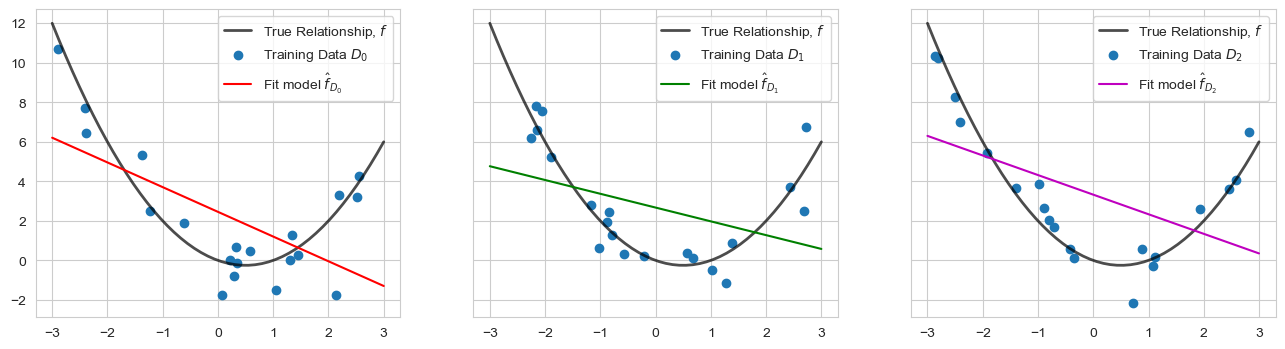

In [25]:
fig,ax = plt.subplots(1,3,figsize = (16,4), sharex = True, sharey = True)

xs = np.linspace(-3,3)

colors = {0: 'r', 1: 'g', 2:'m'}

regs = [LinearRegression(), LinearRegression(), LinearRegression()]
for i in range(3):
    ax[i].plot(xs, xs*(xs-1),'k', label = "True Relationship, $f$", alpha = .7, linewidth=2)
    ax[i].scatter(x[:,i], y[:,i], label = "Training Data $D_%i$" %i)

    regs[i].fit(x[:,i].reshape(-1,1),y[:,i])
    ax[i].plot(xs, regs[i].predict(xs.reshape(-1,1)), label = "Fit model $\\hat{f}_{D_%i}$" %i, c = colors[i])

    ax[i].legend(fontsize=10)


plt.show()


Now imagine fitting millions of models this way.  The average of all of the fitted models would be $\bar{f}$

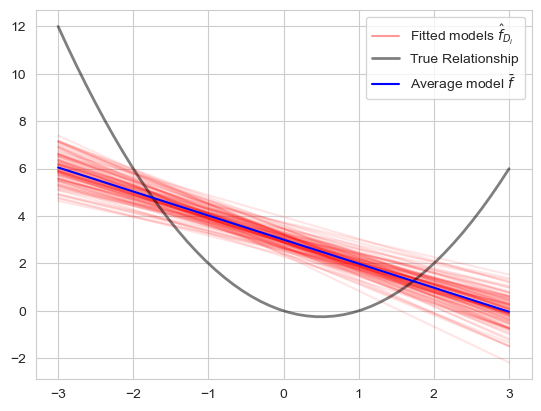

In [26]:
avg_model = 0*xs
for i in range(100):

    # First generate a random training set
    x = np.random.uniform(low=-3, high = 3, size = (100,))
    y = x*(x-1) + 1.2*np.random.randn(100)

    # Now fit the high variance model
    slr = LinearRegression()

    slr.fit(x.reshape(-1,1),y)

    slr_preds = slr.predict(xs.reshape(-1,1))

    avg_model += slr_preds

    plt.plot(xs, slr_preds, alpha = 0.1, c = 'r')

avg_model = avg_model/100.0

plt.plot(xs, slr_preds, alpha = 0.4, c = 'r', label = "Fitted models $\\hat{f}_{D_i}$")
plt.plot(xs, xs*(xs-1),'k', label = "True Relationship", alpha = 0.5, linewidth=2)
plt.plot(xs, avg_model,'b', label = "Average model $\\bar{f}$")

plt.legend(fontsize=10)

plt.show()

The linear regression model will have a **low variance** and **high bias** in this case:

*  The variance is low since the estimates $\hat{f}_{D_i}$ are all close to each other.  
*  The bias is high since even the best linear estimator of the true relationship will be a poor fit.  The true relationship just isn't linear!

This kind of of model is said to **underfit** the data.

### A model with high variance but low bias

A regression model with low bias but high variance would be to use a degree 5 polynomial of $x$:

In [27]:
## Ignore Pipeline and PolynomialFeatures
## We will touch on these in a video soon
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

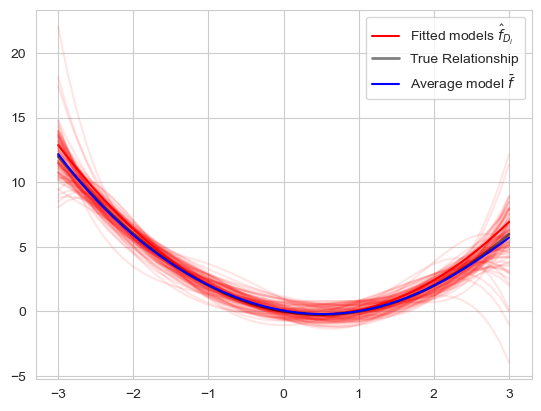

In [28]:
avg_model = 0*xs
for i in range(100):

    # First generate a random training set
    x = rng.uniform(low=-3, high = 3, size = (30,))
    y = x*(x-1) + 1.2*rng.standard_normal(30)

    # Now fit the high variance model
    high_deg_pipe = Pipeline([('poly',PolynomialFeatures(5)),
                             ('reg', LinearRegression(copy_X = True))])

    high_deg_pipe.fit(x.reshape(-1,1),y)

    high_deg_curve = high_deg_pipe.predict(xs.reshape(-1,1))

    avg_model += high_deg_curve

    plt.plot(xs, high_deg_curve, alpha = 0.1, c = 'r')

avg_model = avg_model/100.0

plt.plot(xs, 1.1*xs*(xs-0.9),'r', label = "Fitted models $\\hat{f}_{D_i}$")
plt.plot(xs, xs*(xs-1),'k', label = "True Relationship", alpha = 0.5, linewidth=2)
plt.plot(xs, avg_model,'b', label = "Average model $\\bar{f}$")

plt.legend(fontsize=10)

plt.show()

Here the mean $\bar{f}$ over all models is really close to the true relationship $f$, but the variance in the models is quite high (especially due to the variance near the endpoints).

### The model with the best balance of variance and bias

For this particular problem fitting a polynomial of degree two is the most appropriate choice!

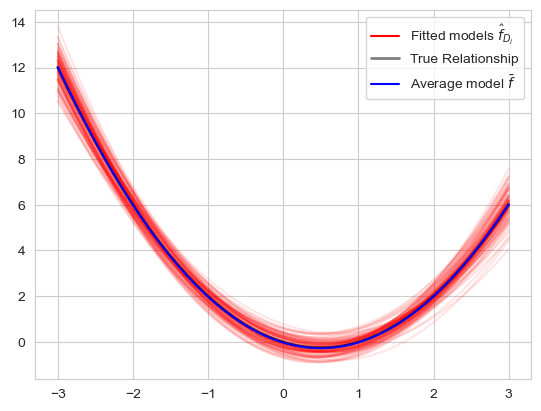

In [29]:
avg_model = 0*xs
for i in range(100):

    # First generate a random training set
    x = rng.uniform(low=-3, high = 3, size = (30,))
    y = x*(x-1) + 1.2*rng.standard_normal(30)

    # Now fit the high variance model
    deg_two_pipe = Pipeline([('poly',PolynomialFeatures(2)),
                             ('reg', LinearRegression(copy_X = True))])

    deg_two_pipe.fit(x.reshape(-1,1),y)

    deg_two_curve = deg_two_pipe.predict(xs.reshape(-1,1))

    avg_model += deg_two_curve

    plt.plot(xs, deg_two_curve, alpha = 0.1, c = 'r')

avg_model = avg_model/100.0

plt.plot(xs, xs*(xs-1),'r', label = "Fitted models $\\hat{f}_{D_i}$")
plt.plot(xs, xs*(xs-1),'k', label = "True Relationship", alpha = 0.5, linewidth=2)
plt.plot(xs, avg_model,'b', label = "Average model $\\bar{f}$")

plt.legend(fontsize=10)

plt.show()

This has low bias and variance!  Typically you will not be able to find a model which does both so well, but it was possible in this case because our data was synthetically generated and had a true (systematic) relationship which was actually in our model.

### The trade-off

The model with the lowest generalization error tends to occur somewhere between the higher variance and higher bias.

<img src="lecture_assets/bias_variance.png" width="60%"></img>

--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023. Modified by Steven Gubkin 2024.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)